In [1]:
%load_ext autoreload
%autoreload 2
    
import os, sys
#PWD = os.getenv('PWD')
PWD = '/Users/chris/Documents/lab/emAnalysis/backend/server'

PROJ_MISSING_MSG = """Set an enviroment variable:\n
`DJANGO_PROJECT=your_project_name`\n
or call:\n
`init_django(your_project_name)`
"""

def init_django(project_name=None):
    os.chdir(PWD)
    project_name = project_name or os.environ.get('DJANGO_PROJECT') or None
    if project_name == None:
        raise Exception(PROJ_MISSING_MSG)
    sys.path.insert(0, os.getenv('PWD'))
    os.environ.setdefault('DJANGO_SETTINGS_MODULE', f'{project_name}.settings')
    os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"
    import django
    django.setup()

init_django("server")
from django.conf import settings
media_root = settings.MEDIA_ROOT
import numpy as np
import os
from matplotlib import pyplot as plt
import functools
import math
import sims
import copy
import os
from PIL import Image
from pathlib import Path
import numpy as np
from skimage.measure import regionprops
from scipy import spatial
import pickle
from matplotlib.figure import Figure
import pyvips
from image.models import Image
from core.models import Canvas
from mims.models import MIMSImage, MIMSImageSet
from PIL import Image
from scipy.ndimage import rotate
import pprint
import sims

mims_image_sets/f45f95ee-aae5-4dc3-b467-77167ecb2462/mims_images/1035_position_1.im
1 time1 7.311018943786621
CANVAS viewset x,y coords -40065 -3203
MIMSImage composite coords (3394, 2328)
MIMSImage EM coords 33172.0 12966.25
ok....? [33172.0, 12966.25] (42628, 33469)
time5: 8.105962991714478 [12000, 32109] 0.5462681651115417


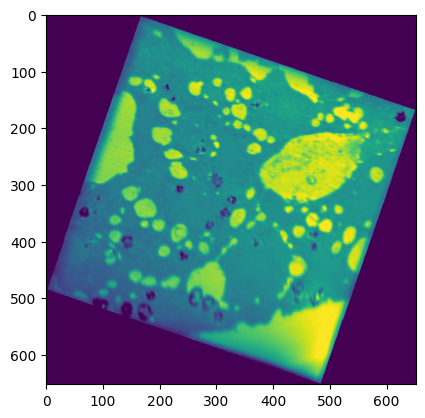

HERE...


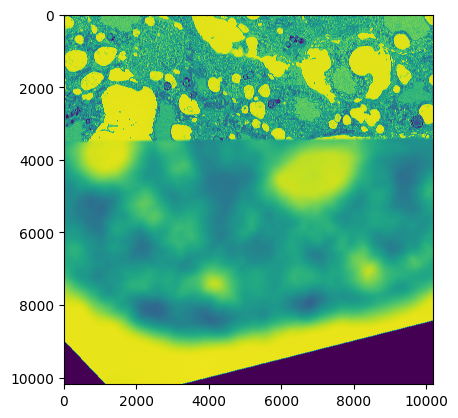

mims_image_sets/f45f95ee-aae5-4dc3-b467-77167ecb2462/mims_images/1035_position_2.im
2 time1 9.062687873840332
CANVAS viewset x,y coords -40065 -3203
MIMSImage composite coords (2958, 1433)
MIMSImage EM coords 19187.625 6153.75
ok....? [19187.625, 6153.75] (42628, 33469)
time5: 9.864922046661377 [5250, 18687] 0.5217872858047485


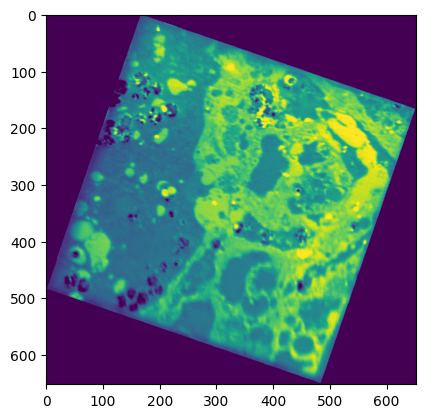

HERE...


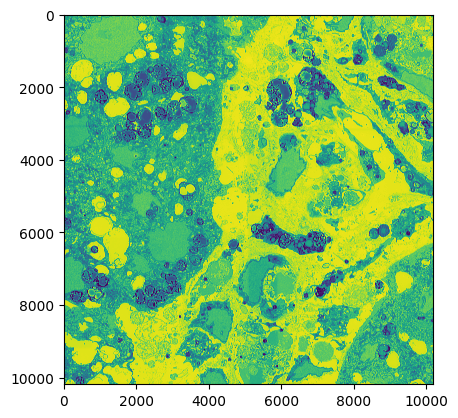

mims_image_sets/f45f95ee-aae5-4dc3-b467-77167ecb2462/mims_images/1035_position_3.im
3 time1 10.869302988052368
CANVAS viewset x,y coords -40065 -3203
MIMSImage composite coords (3733, 875)
MIMSImage EM coords 10468.875 18263.125
ok....? [10468.875, 18263.125] (42628, 33469)
time5: 11.674343824386597 [17046, 9906] 0.4175564646720886


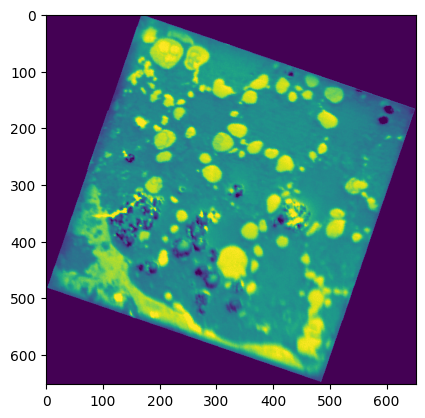

HERE...


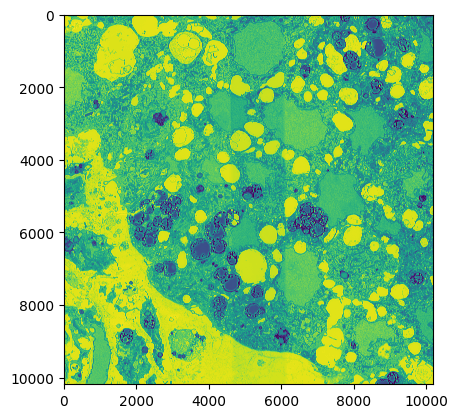

mims_image_sets/f45f95ee-aae5-4dc3-b467-77167ecb2462/mims_images/1035_position_4.im
4 time1 12.62696385383606
CANVAS viewset x,y coords -40065 -3203
MIMSImage composite coords (1167, 817)
MIMSImage EM coords 9562.625 -21830.625
uhoh.... [9562.625, -21830.625] (42628, 33469)
mims_image_sets/f45f95ee-aae5-4dc3-b467-77167ecb2462/mims_images/1035_position_5.im
5 time1 13.388916969299316
CANVAS viewset x,y coords -40065 -3203
MIMSImage composite coords (1207, 1563)
MIMSImage EM coords 21218.875 -21205.625
uhoh.... [21218.875, -21205.625] (42628, 33469)
mims_image_sets/f45f95ee-aae5-4dc3-b467-77167ecb2462/mims_images/1035_position_6.im
6 time1 14.134204864501953
CANVAS viewset x,y coords -40065 -3203
MIMSImage composite coords (333, 2493)
MIMSImage EM coords 35750.125 -34861.875
uhoh.... [35750.125, -34861.875] (42628, 33469)
mims_image_sets/f45f95ee-aae5-4dc3-b467-77167ecb2462/mims_images/1035_position_7.im
7 time1 14.888242959976196
CANVAS viewset x,y coords -40065 -3203
MIMSImage composit

In [16]:
from mims.services.concat_utils import get_concatenated_image, get_autocontrast_image_path
import cv2
from PIL import ImageOps
import time

def largest_inner_square(side_length, angle):
    """Calculate the largest possible inner square side length for a given rotation angle."""
    # Convert angle to radians
    return side_length / (abs(math.cos(math.radians(angle))) + abs(math.sin(math.radians(angle))))

def calculate_individual_mims_translations(mims_imageviewset):
    start = time.time()
    # Print seconds elapsed
    mims_images = mims_imageviewset.mims_images.all()
    # Get transformation parameters
    flip = mims_imageviewset.flip
    rotation_degrees = mims_imageviewset.rotation_degrees
    isotope = "SE" #mims_images[0].isotopes.all()[0]
    composite_image = Image.fromarray(get_concatenated_image(imageviewset, isotope))
    if isotope == "32S":
        composite_image = ImageOps.invert(composite_image)
    if flip:
        composite_image = composite_image.transpose(Image.FLIP_LEFT_RIGHT)
    composite_image = composite_image.rotate(rotation_degrees, expand=True)
    composite_image = np.array(composite_image)
    em_image_obj = mims_imageviewset.canvas.images.first()
    scale = mims_imageviewset.mims_images.first().pixel_size_nm / (em_image_obj.pixel_size_nm or 5)
    # Load the EM image as a numpy array
    em_image = Image.open(em_image_obj.file.path)
    em_image_array = np.array(em_image)
    scaled_em = cv2.resize(em_image_array, (int(em_image_array.shape[1] / scale), int(em_image_array.shape[0] / scale)))
    # Calculate and store translations for each MIMS image
    for mims_image in mims_images:
        print(mims_image)
        filename = mims_image.file.name.split("/")[-1].split(".")[0]
        roi = filename.split("_")[-1]
        print(roi, "time1", time.time()-start)
        # Load the MIMS image for the isotope and load as PIL image
        img_orig = get_autocontrast_image_path(mims_image, isotope)
        img_orig = Image.open(img_orig)
        if isotope == "32S":
            img_orig = ImageOps.invert(img_orig)
        img = img_orig.copy()
        # Apply the flip and rotation if necessary to it
        img = img.rotate(-rotation_degrees, expand=True)
        if flip:
            img = img.transpose(Image.FLIP_LEFT_RIGHT)
        img_array = np.array(img)
        
        # Calculate the center of the image
        center_x, center_y = img_array.shape[1] // 2, img_array.shape[0] // 2

        # Calculate the cropping box
        largest_inner_square_side = int(largest_inner_square(img_orig.width, rotation_degrees))
        start_x = center_x - largest_inner_square_side // 2
        start_y = center_y - largest_inner_square_side // 2
        end_x = center_x + largest_inner_square_side // 2
        end_y = center_y + largest_inner_square_side // 2

        # Crop the image to the largest inner square
        cropped_img_array = img_array[start_y:end_y, start_x:end_x]
        orig_cropped_img_array_shape = cropped_img_array.shape

        # Then find the image in the composite image
        result = cv2.matchTemplate(composite_image, img_array, cv2.TM_CCOEFF_NORMED)
        print("CANVAS viewset x,y coords", mims_imageviewset.canvas_x, mims_imageviewset.canvas_y)
        _, max_val, _, max_loc = cv2.minMaxLoc(result)
        print("MIMSImage composite coords", max_loc)
        # Now from this approximation, find a closer match in the actual EM image
        # Find the original EM location of the MIMS image
        mims_y =  mims_imageviewset.canvas_y + max_loc[1]*scale
        mims_x = mims_imageviewset.canvas_x + max_loc[0]*scale
        print("MIMSImage EM coords", mims_y, mims_x)
        mims_scaled_shape = np.array(img_orig).shape
        em_orig_shape = em_image_array.shape
        # Skip if sufficiently far outside of the known EM bounds
        approx_em_loc = [mims_y, mims_x]
        if (approx_em_loc[0] < -mims_scaled_shape[0] or 
            approx_em_loc[0] > em_orig_shape[0] + mims_scaled_shape[0] or 
            approx_em_loc[1] < -mims_scaled_shape[1] or
            approx_em_loc[1] > em_orig_shape[1] + mims_scaled_shape[1]):
            print("uhoh....", approx_em_loc, em_orig_shape)
            mims_image.status = "NO_CELLS"
            mims_image.save()
            continue
        print("ok....?", approx_em_loc, em_orig_shape)
        # Then scale it down
        mims_y_scaled = mims_y / scale
        mims_x_scaled = mims_x / scale
        crop_size = int(img_array.shape[0] * 1.3)
        crop_y_start = max(mims_y_scaled - crop_size*0.5, 0)
        crop_y_end = min(mims_y_scaled + (crop_size*1.5), scaled_em.shape[0])
        crop_x_start = max(mims_x_scaled - (crop_size*0.5), 0)
        crop_x_end = min(mims_x_scaled + (crop_size*1.5), scaled_em.shape[1])
        scaled_em_crop = scaled_em[int(crop_y_start):int(crop_y_end), int(crop_x_start):int(crop_x_end)]
        y_size_limit = int(scaled_em.shape[0] - mims_y_scaled)
        if (y_size_limit) < cropped_img_array.shape[0]:
            if crop_y_start == 0:
                cropped_img_array = cropped_img_array[-y_size_limit:, :]
            else:
                cropped_img_array = cropped_img_array[:y_size_limit, :]
        x_size_limit = int(scaled_em.shape[1] - mims_x_scaled)
        if (x_size_limit) < cropped_img_array.shape[1]:
            if crop_x_start == 0:
                cropped_img_array = cropped_img_array[:, -x_size_limit :]
            else:
                cropped_img_array = cropped_img_array[:, :x_size_limit ]
        # Now find the MIMS image in the crop
        # These 2 calls take ~0.3 seconds
        if cropped_img_array.shape[0] == 0 or cropped_img_array.shape[1] == 0:
            mims_image.status = "NO_CELLS"
            mims_image.save()
            continue
        result = cv2.matchTemplate(scaled_em_crop, cropped_img_array, cv2.TM_CCOEFF_NORMED)
        _, max_val, _, max_loc = cv2.minMaxLoc(result)
        adjustment = (img_array.shape[0] - orig_cropped_img_array_shape[0]) // 2
        scaled_cropped_em_y_start = max(max_loc[1] - adjustment,0)
        scaled_em_y_start = int(crop_y_start + scaled_cropped_em_y_start)
        em_y_start = int(scaled_em_y_start*scale)
        em_y_end = int(em_y_start + img_array.shape[0]*scale)
        scaled_cropped_em_x_start = max(max_loc[0] - adjustment,0)
        scaled_em_x_start = int(crop_x_start + scaled_cropped_em_x_start)
        em_x_start = int(scaled_em_x_start*scale)
        em_x_end = int(em_x_start + img_array.shape[1]*scale)
        print("time5:", time.time()-start, [em_x_start, em_y_start], max_val)
        
        # Calculate the translation in the EM image
        plt.imshow(img_array)
        plt.show()
        mims_image.alignments.all().delete()
        mims_image.alignments.create(
            x_offset=em_x_start,
            y_offset=em_y_start,
            flip_hor=flip,
            rotation_degrees=rotation_degrees,
            scale=scale, status="GUESS"
        )
        mims_image.status = "NEED_USER_ALIGNMENT"
        mims_image.save()
        print("HERE...")
        em_cropped_img = em_image_array[em_y_start:em_y_end, em_x_start:em_x_end]
        #c13_map = Image.open(get_autocontrast_image_path(mims_image, "13C12C_ratio"))
        # Apply the flip and rotation if necessary to it
        #c13_map = c13_map.rotate(-rotation_degrees, expand=True)
        #if flip:
        #    c13_map = c13_map.transpose(Image.FLIP_LEFT_RIGHT)
        #c13_map = np.array(c13_map)
        #c13_map = cv2.resize(c13_map, (int(c13_map.shape[1] * scale), int(c13_map.shape[0] * scale)))
        #Image.fromarray(c13_map).save(f"/Users/chris/Documents/lab/experiments/2023_HFD-CD_13C_glucose/CD2_mouse_data/liver/mims_em_crops/initial_c13/{filename}.tiff")
        #Image.fromarray(em_cropped_img).save(f"/Users/chris/Documents/lab/experiments/2023_HFD-CD_13C_glucose/CD2_mouse_data/liver/mims_em_crops/initial_em/{filename}.tiff")
        #scaled_mims_orig = ImageOps.invert(Image.fromarray(scaled_mims))
        #scaled_mims_orig.save(f"/Users/chris/Documents/lab/experiments/2023_HFD-CD_13C_glucose/CD2_mouse_data/liver/mims_em_crops/initial_mims/{filename}.tiff")
        plt.imshow(em_cropped_img)
        plt.show()
    return

imageviewset = MIMSImageSet.objects.get(id="f45f95ee-aae5-4dc3-b467-77167ecb2462")
calculate_individual_mims_translations(imageviewset)

In [58]:
import os
from PIL import Image
from pathlib import Path
import numpy as np

def process_images(base_folder):
    # Loop through all child directories
    for root, dirs, files in os.walk(base_folder):
        # Look for "registration" subfolder
        if "registration" in root:
            folder_roi_name = root.split("/")[-2]
            im_file = os.path.join(Path(root).parent.parent, folder_roi_name + ".im")
            mims_imageset_id = Path(root).parent.parent.parent.stem
            imageset = MIMSImageSet.objects.get(id=mims_imageset_id)
            mims_image_obj = imageset.mims_images.filter(file__contains=folder_roi_name).first()
            alignment = mims_image_obj.alignments.filter(status="FINAL_TWEAKED_ONE").first()
            if not alignment or not Path(im_file).exists(): 
                continue
            scale = alignment.scale

            print(root)
            mims = sims.SIMS(im_file)
            mims_meta = mims.header["Image"]
            mims_pixel_size = mims_meta["raster"] / mims_meta["width"]
            all_species = mims.data.species.values
            isotope_image_dir = os.path.join(Path(root).parent, "isotopes")
            if "12C" in all_species and "13C" in all_species:
                c12_im = np.asarray(Image.open(os.path.join(isotope_image_dir, "12C.png")))
                c13_im = np.asarray(Image.open(os.path.join(isotope_image_dir, "13C.png")))
                ratio = Image.fromarray(
                    (np.divide(c13_im, c12_im) * 10000).astype(np.uint16)
                )
                if alignment.flip_hor:
                    ratio = ratio.transpose(Image.FLIP_LEFT_RIGHT)
                ratio = ratio.rotate(-alignment.rotation_degrees, expand=True)
                ratio = np.array(ratio)
                ratio = cv2.resize(
                    ratio,
                    (
                        int(ratio.shape[1] * scale),
                        int(ratio.shape[0] * scale),
                    ),
                )
                ratio = Image.fromarray(ratio)
                ratio.save(os.path.join(root, "13C12C_ratio_final.tiff"))
            if "15N 12C" in all_species and "14N 12C" in all_species:
                n15_im = np.asarray(
                    Image.open(os.path.join(isotope_image_dir, "15N 12C.png"))
                )
                n14_im = np.asarray(
                    Image.open(os.path.join(isotope_image_dir, "14N 12C.png"))
                )
                ratio = Image.fromarray(
                    (np.divide(n15_im, n14_im) * 10000).astype(np.uint16)
                )
                if alignment.flip_hor:
                    ratio = ratio.transpose(Image.FLIP_LEFT_RIGHT)
                ratio = ratio.rotate(-alignment.rotation_degrees, expand=True)
                ratio = np.array(ratio)
                ratio = cv2.resize(
                    ratio,
                    (
                        int(ratio.shape[1] * scale),
                        int(ratio.shape[0] * scale),
                    ),
                )
                ratio = Image.fromarray(ratio)
                ratio.save(os.path.join(isotope_image_dir, "15N14N_ratio.tiff"))
"""
baseDirectory = "/Users/chris/Documents/lab/emAnalysis/backend/server/media/mims_image_sets/cafc510b-45ea-4798-b30c-869e0bb706ba/mims_images"; 
process_images(baseDirectory)
"""

/Users/chris/Documents/lab/emAnalysis/backend/server/media/mims_image_sets/cafc510b-45ea-4798-b30c-869e0bb706ba/mims_images/Mouse-lvr_area4_2/registration
/Users/chris/Documents/lab/emAnalysis/backend/server/media/mims_image_sets/cafc510b-45ea-4798-b30c-869e0bb706ba/mims_images/Mouse-lvr_area4_28/registration
/Users/chris/Documents/lab/emAnalysis/backend/server/media/mims_image_sets/cafc510b-45ea-4798-b30c-869e0bb706ba/mims_images/Mouse-lvr_area4_27/registration


/var/folders/v5/v1r03h0s3f50cyrz1tz2sfqc0000gn/T/ipykernel_39064/2349671389.py:54: RuntimeWarning: divide by zero encountered in divide
  (np.divide(n15_im, n14_im) * 10000).astype(np.uint16)
/var/folders/v5/v1r03h0s3f50cyrz1tz2sfqc0000gn/T/ipykernel_39064/2349671389.py:54: RuntimeWarning: invalid value encountered in divide
  (np.divide(n15_im, n14_im) * 10000).astype(np.uint16)
/var/folders/v5/v1r03h0s3f50cyrz1tz2sfqc0000gn/T/ipykernel_39064/2349671389.py:54: RuntimeWarning: invalid value encountered in cast
  (np.divide(n15_im, n14_im) * 10000).astype(np.uint16)


/Users/chris/Documents/lab/emAnalysis/backend/server/media/mims_image_sets/cafc510b-45ea-4798-b30c-869e0bb706ba/mims_images/Mouse-lvr_area4_18/registration
/Users/chris/Documents/lab/emAnalysis/backend/server/media/mims_image_sets/cafc510b-45ea-4798-b30c-869e0bb706ba/mims_images/Mouse-lvr_area4_16/registration


In [68]:
"""output_dir = "/Users/chris/Documents/lab/emAnalysis/backend/server/media/temp_holder"

def process_images(base_folder):
    has = 0
    hasnt = 0
    # Loop through all child directories
    for root, dirs, files in os.walk(base_folder):
        if "registration" in root:
            folder_roi_name = root.split("/")[-2]
            em_file = os.path.join(Path(root), "em_final.png")
            if Path(em_file).exists():
                has += 1
                Image.open(em_file).save(os.path.join(output_dir, folder_roi_name + "__em_final.tiff"))
            else:
                hasnt += 1
"""

"""baseDirectory = "/Users/chris/Documents/lab/emAnalysis/backend/server/media/mims_image_sets/"
for end in ["cafc510b-45ea-4798-b30c-869e0bb706ba", "1fa48d45-3fea-4593-b1ae-11f7f9b9e066", "12e93eea-2ab8-4f5b-8c6a-7a085560fbcc"]:
  directory = baseDirectory + end + "/mims_images"; 
  process_images(directory)

"""

In [ ]:
from mims.services.registration_utils import create_composite_mask, create_registration_images, scale_between_masks, test_mask_iou


imageset = MIMSImageSet.objects.get(id="f45f95ee-aae5-4dc3-b467-77167ecb2462")
name = "1035_position_2"

for mims_image in imageset.mims_images.all():
    if name not in mims_image.file.name:
        continue
    old_alignment = mims_image.alignments.filter(status="USER_ROUGH_ALIGNMENT").first()
    reg_loc = os.path.join(media_root, "mims_image_sets", str(imageset.id), "mims_images", name, "registration")
    
    em_mask = np.asarray(Image.open(os.path.join(reg_loc, "em_mask_orig.png")))
    mims_mask_orig = np.asarray(Image.open(os.path.join(reg_loc, "mims_mask_orig.png")))
    # Create a composite mask
    composite_mask = create_composite_mask(em_mask, mims_mask_orig)
    Image.fromarray(composite_mask).save(os.path.join(reg_loc, "composite_mask_orig.png"))
    orig_iou, orig_translation = test_mask_iou(em_mask, mims_mask_orig)
    # Make an image with both masks, where one set is 
    # first test the scale if needed: take furthest points and calculate distances
    # Get bounding box of 1s for each mask
    furthest_points_scale = scale_between_masks(em_mask, mims_mask_orig)
    # Scale the mims mask up by avg_dist
    mims_mask_test = cv2.resize(mims_mask_orig, (int(mims_mask_orig.shape[1] * furthest_points_scale), int(mims_mask_orig.shape[0] * furthest_points_scale)))
    scaled_iou, scaled_translation = test_mask_iou(em_mask, mims_mask_test)
    
    
    mims_to_use = mims_mask_orig
    translation_to_use = orig_translation
    if scaled_iou > orig_iou:
        mims_to_use = mims_mask_test
        translation_to_use = scaled_translation
    em_mask_padding = max(abs(translation_to_use[0]), abs(translation_to_use[1]))
    em_padded_y_start = em_mask_padding + translation_to_use[1]
    em_padded_y_end = em_padded_y_start + mims_to_use.shape[0]
    em_padded_x_start = em_mask_padding + translation_to_use[0]
    em_padded_x_end = em_padded_x_start + mims_to_use.shape[1]
    em_mask_translated = np.pad(em_mask, em_mask_padding, mode="constant")[
        em_padded_y_start:em_padded_y_end, em_padded_x_start:em_padded_x_end
    ]

    mims_image.alignments.filter(status="FINAL_TWEAKED_ONE").delete()
    scale = old_alignment.scale
    if scaled_iou > orig_iou:
        scale *= furthest_points_scale
    alignment = MIMSAlignment.objects.create(
        mims_image=mims_image,
        x_offset=old_alignment.x_offset,
        y_offset=old_alignment.y_offset,
        rotation_degrees=old_alignment.rotation_degrees,
        flip_hor=old_alignment.flip_hor,
        scale=scale,
        status="FINAL_TWEAKED_ONE",
    )
    alignment.x_offset += translation_to_use[0]
    alignment.y_offset += translation_to_use[1]
    alignment.save()

    # Optionally create and save registration images
    create_registration_images(
        mims_image,
        masks={"em_mask": em_mask_translated, "mims_mask": mims_to_use},
    )
    mims_image.status = "DEWARP PENDING"
    mims_image.save()